# 1. Introduction
With this study we aim to accomplish the following:

1. Identify and visualize which factors contribute to customer churn:

2. Build a prediction model that will perform the following:

    * Classify if a customer is going to churn or not
    * Preferably and based on model performance, choose a model that will attach a probability to the churn to make it easier for customer service to target low hanging fruits in their efforts to prevent churn


# 2. Dataset review & preparation
We will seek to explore the structure of our data:

    1. To understand the input space the data set
    2. And to prepare the sets for exploratory and prediction tasks as described in section 1

import tensorflow as tf
print(tf.__version__)

In [95]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers

# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [96]:
# reading the CSV file into pandas dataframe
df = pd.read_csv("bank.csv")  

pd.isnull(df).count()

RowNumber          10000
CustomerId         10000
Surname            10000
CreditScore        10000
Geography          10000
Gender             10000
Age                10000
Tenure             10000
Balance            10000
NumOfProducts      10000
HasCrCard          10000
IsActiveMember     10000
EstimatedSalary    10000
Exited             10000
dtype: int64

In [97]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [98]:
df.shape

(10000, 14)

The Df has 10000 rows with 14 attributes. We review this further to identify what attributes will be necessary and what data manipulation needs to be carried out before Exploratory analysis and prediction modelling

In [99]:
# Check columns list and missing values
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Well isn't that a rare find; no missing values!

In [100]:
# Get unique count for each variable
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

From the above, we will not require the first 2 attributes as the are specific to a customer. It is borderline with the surname as this would result to profiling so we exclude this as well.

In [101]:
# Drop the columns as explained above
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

In [102]:
# Review the top rows of what is left of the data frame
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


From the above, following questions arises

1) The data appears to be a snapshot as some point in time e.g. the balance is for a given date which leaves a lot of questions:
    * What date is it and of what relevance is this date
    * Would it be possible to obtain balances over a period of time as opposed to a single date.
    
2) There are customers who have exited but still have a balance in their account! What would this mean? Could they have exited from a product and not the bank?

3) What does being an active member mean and are there difference degrees to it? Could it be better to provide transaction count both in terms of credits and debits to the account instead?

4) A break down to the products bought into by a customer could provide more information topping listing of product count

For this exercise, we proceed to model without context even though typically having context and better understanding of the data extraction process would give better insight and possibly lead to better and contextual results of the modelling process

In [103]:
# Check variable data types
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

So we moslty have categorical variables and 5 continuous variables

# 3. Exploratory Data Analysis
Here our main interest is to get an understanding as to how the given attributes relate too the 'Exit' status.

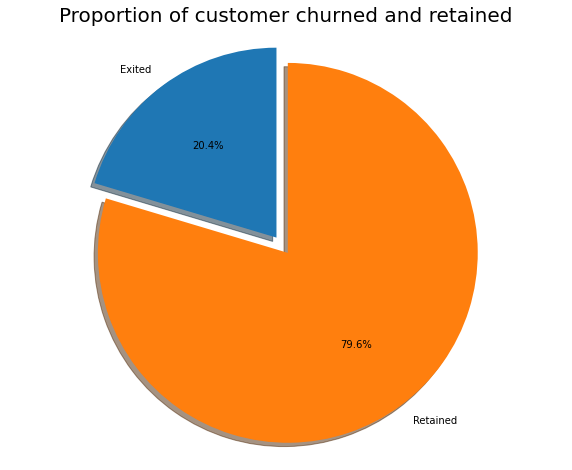

In [104]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

So about 20% of the customers have churned. So the baseline model could be to predict that 20% of the customers will churn. Given 20% is a small number, we need to ensure that the chosen model does predict with great accuracy this 20% as it is of interest to the bank to identify and keep this bunch as opposed to accurately predicting the customers that are retained.

<AxesSubplot:xlabel='IsActiveMember', ylabel='count'>

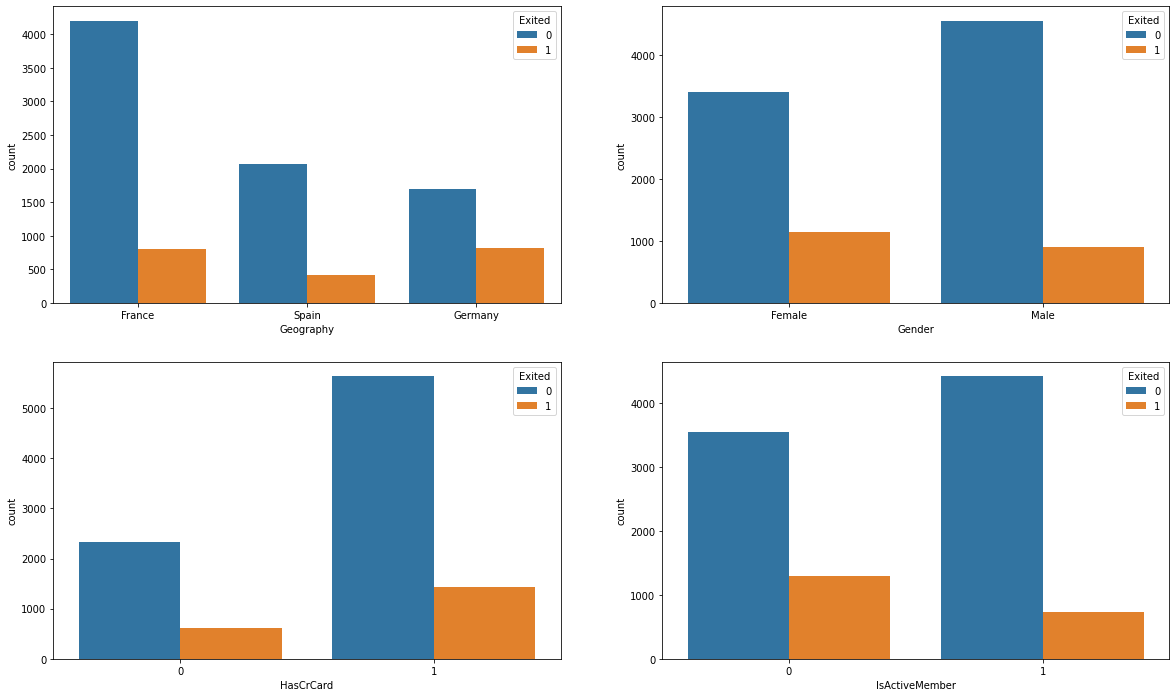

In [105]:
 # We first review the 'Status' relation with categorical variables
    
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

We note the following:

    * Majority of the data is from persons from France. However, the proportion of churned customers is with inversely related to the population of customers alluding to the bank possibly having a problem (maybe not enough customer service resources allocated) in the areas where it has fewer clients.
    * The proportion of female customers churning is also greater than that of male customers
    * Interestingly, majority of the customers that churned are those with credit cards. Given that majority of the customers have credit cards could prove this to be just a coincidence.
    * Unsurprisingly the inactive members have a greater churn. Worryingly is that the overall proportion of inactive mebers is quite high suggesting that the bank may need a program implemented to turn this group to active customers as this will definately have a positive impact on the customer churn.

<AxesSubplot:xlabel='Exited', ylabel='EstimatedSalary'>

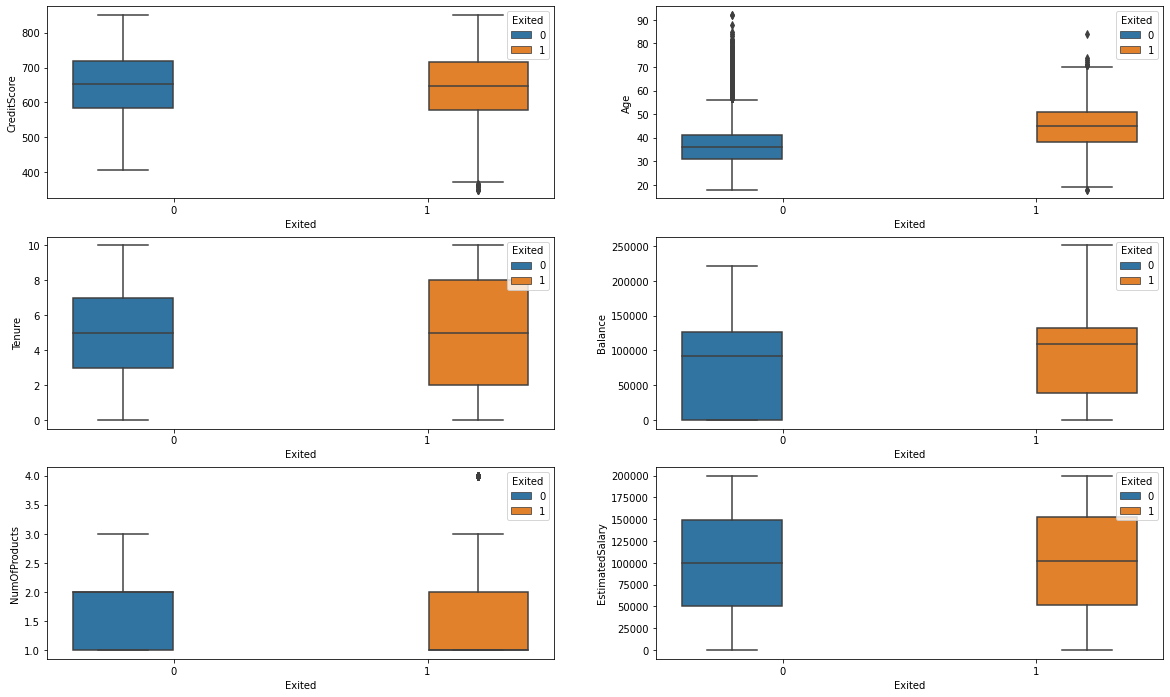

In [106]:
    # Relations based on the continuous data attributes
    fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
    sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
    sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
    sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
    sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
    sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
    sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])

We note the following:

* There is no significant difference in the credit score distribution between retained and churned customers.
* The older customers are churning at more than the younger ones alluding to a difference in service preference in the age categories. The bank may need to review their target market or review the strategy for retention between the different age groups
* With regard to the tenure, the clients on either extreme end (spent little time with the bank or a lot of time with the bank) are more likely to churn compared to those that are of average tenure.
* Worryingly, the bank is losing customers with significant bank balances which is likely to hit their available capital for lending.
* Neither the product nor the salary has a significant effect on the likelyhood to churn.

# 4. Feature engineering
We seek to add features that are likely to have an impact on the probability of churning. We first split the train and test sets

Remember that Gender and Geography need to be enconded, so let’s use get_dummies

In [109]:
df_hot = pd.get_dummies(df)

In [110]:
df_hot.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


#### In order to train our model and later test its accuracy, we need to split the data into two datasets. In ANN feature scaling is very important so that all inputs are at a comparable range and only the weights assigned to them are, in fact, the only factor which makes a difference on the predicted value.

In [111]:
features = [col for col in df_hot.columns if col != 'Exited']

X_train, X_test, y_train, y_test = train_test_split(df_hot[features], df_hot['Exited'], test_size=.3, random_state=22)
X_train.shape, X_test.shape

((7000, 13), (3000, 13))

#### Scaling data

In [112]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# 5. Creating our Artificial Neural Network!
So, now that you’re more instructed on ANN here is a summary of all the steps you need to take to build and train an Artificial Neural Network! Let’s refresh our memories!

### Now we will run ANN model with 1 input , 2 hidden layer using sgd optimizer

In [113]:
classifier_sgd = Sequential()

classifier_sgd.add(Dense(units = 16, activation = 'relu',input_dim = 13))
classifier_sgd.add(Dense(units = 12, activation = 'tanh'))
classifier_sgd.add(Dense(units = 1,  activation = 'sigmoid'))
classifier_sgd.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics=['accuracy'])
model_sgd=classifier_sgd.fit(X_train, y_train ,validation_split=0.33, batch_size = 10, epochs = 100)

Train on 4689 samples, validate on 2311 samples
Epoch 1/100
4689/4689 [==============================] - 2s 368us/sample - loss: 0.5346 - accuracy: 0.7820 - val_loss: 0.4992 - val_accuracy: 0.7897
Epoch 2/100
4689/4689 [==============================] - 1s 242us/sample - loss: 0.4684 - accuracy: 0.8036 - val_loss: 0.4617 - val_accuracy: 0.7979
Epoch 3/100
4689/4689 [==============================] - 1s 218us/sample - loss: 0.4449 - accuracy: 0.8098 - val_loss: 0.4433 - val_accuracy: 0.8044
Epoch 4/100
4689/4689 [==============================] - 1s 211us/sample - loss: 0.4332 - accuracy: 0.8128 - val_loss: 0.4323 - val_accuracy: 0.8109
Epoch 5/100
4689/4689 [==============================] - 1s 205us/sample - loss: 0.4248 - accuracy: 0.8134 - val_loss: 0.4239 - val_accuracy: 0.8139
Epoch 6/100
4689/4689 [==============================] - 1s 230us/sample - loss: 0.4178 - accuracy: 0.8168 - val_loss: 0.4165 - val_accuracy: 0.8165
Epoch 7/100
4689/4689 [==============================] - 1

4689/4689 [==============================] - 1s 180us/sample - loss: 0.3155 - accuracy: 0.8691 - val_loss: 0.3581 - val_accuracy: 0.8507
Epoch 56/100
4689/4689 [==============================] - 1s 206us/sample - loss: 0.3160 - accuracy: 0.8684 - val_loss: 0.3521 - val_accuracy: 0.8537
Epoch 57/100
4689/4689 [==============================] - 1s 186us/sample - loss: 0.3154 - accuracy: 0.8691 - val_loss: 0.3536 - val_accuracy: 0.8520
Epoch 58/100
4689/4689 [==============================] - 1s 182us/sample - loss: 0.3149 - accuracy: 0.8680 - val_loss: 0.3534 - val_accuracy: 0.8542
Epoch 59/100
4689/4689 [==============================] - 1s 191us/sample - loss: 0.3145 - accuracy: 0.8701 - val_loss: 0.3551 - val_accuracy: 0.8533
Epoch 60/100
4689/4689 [==============================] - 1s 191us/sample - loss: 0.3145 - accuracy: 0.8671 - val_loss: 0.3551 - val_accuracy: 0.8555
Epoch 61/100
4689/4689 [==============================] - 1s 175us/sample - loss: 0.3146 - accuracy: 0.8693 - val

In [114]:
# Predict
y_pred_sgd = classifier_sgd.predict(X_test)
#Threshold of 50%
y_pred_sgd = (y_pred_sgd > 0.5)
cm = confusion_matrix(y_test, y_pred_sgd)
print("=====================Confusion Matrix=======================================")
print(cm)
print("=====================Classification report=======================================")
print(classification_report(y_test, y_pred_sgd))

=====================Confusion Matrix=======================================
[[2264  130]
 [ 306  300]]
=====================Classification report=======================================
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2394
           1       0.70      0.50      0.58       606

    accuracy                           0.85      3000
   macro avg       0.79      0.72      0.75      3000
weighted avg       0.84      0.85      0.84      3000



# 6. Evaluating, Improving and Tuning the ANN.

## For evaluating the model we will use recall as we want to retain the customers as many as possible to let the existing business thrive. 

### Now we will run ANN model with 1 input , 2 hidden layer using adam optimizer

In [119]:
classifier_adam = Sequential()

classifier_adam.add(Dense(units = 16, activation = 'relu',input_dim = 13))
classifier_adam.add(Dense(units = 12, activation = 'relu'))
classifier_adam.add(Dense(units = 1,  activation = 'sigmoid'))
classifier_adam.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
classifier_adam.fit(X_train, y_train , validation_split=0.33, batch_size = 10, epochs = 100)

Train on 4689 samples, validate on 2311 samples
Epoch 1/100
4689/4689 [==============================] - 1s 284us/sample - loss: 0.4861 - accuracy: 0.7940 - val_loss: 0.4458 - val_accuracy: 0.8005
Epoch 2/100
4689/4689 [==============================] - 1s 155us/sample - loss: 0.4280 - accuracy: 0.8174 - val_loss: 0.4248 - val_accuracy: 0.8144
Epoch 3/100
4689/4689 [==============================] - 1s 156us/sample - loss: 0.4132 - accuracy: 0.8241 - val_loss: 0.4136 - val_accuracy: 0.8248
Epoch 4/100
4689/4689 [==============================] - 1s 160us/sample - loss: 0.3996 - accuracy: 0.8322 - val_loss: 0.4010 - val_accuracy: 0.8260
Epoch 5/100
4689/4689 [==============================] - 1s 155us/sample - loss: 0.3872 - accuracy: 0.8371 - val_loss: 0.3909 - val_accuracy: 0.8386
Epoch 6/100
4689/4689 [==============================] - 1s 162us/sample - loss: 0.3730 - accuracy: 0.8433 - val_loss: 0.3740 - val_accuracy: 0.8425
Epoch 7/100
4689/4689 [==============================] - 1

4689/4689 [==============================] - 1s 153us/sample - loss: 0.3085 - accuracy: 0.8731 - val_loss: 0.3563 - val_accuracy: 0.8537
Epoch 56/100
4689/4689 [==============================] - 1s 152us/sample - loss: 0.3076 - accuracy: 0.8686 - val_loss: 0.3638 - val_accuracy: 0.8473
Epoch 57/100
4689/4689 [==============================] - 1s 155us/sample - loss: 0.3071 - accuracy: 0.8720 - val_loss: 0.3614 - val_accuracy: 0.8520
Epoch 58/100
4689/4689 [==============================] - 1s 156us/sample - loss: 0.3068 - accuracy: 0.8731 - val_loss: 0.3582 - val_accuracy: 0.8542
Epoch 59/100
4689/4689 [==============================] - 1s 158us/sample - loss: 0.3070 - accuracy: 0.8725 - val_loss: 0.3580 - val_accuracy: 0.8550
Epoch 60/100
4689/4689 [==============================] - 1s 153us/sample - loss: 0.3055 - accuracy: 0.8723 - val_loss: 0.3614 - val_accuracy: 0.8542
Epoch 61/100
4689/4689 [==============================] - 1s 153us/sample - loss: 0.3074 - accuracy: 0.8716 - val

In [120]:
# Predict
y_pred_adam = classifier_adam.predict(X_test)
#Threshold of 50%
y_pred_adam = (y_pred_adam > 0.5)
cm = confusion_matrix(y_test, y_pred_adam)
print("=====================Confusion Matrix=======================================")
print(cm)
print("=====================Classification report=======================================")
print(classification_report(y_test, y_pred_adam))

=====================Confusion Matrix=======================================
[[2259  135]
 [ 322  284]]
=====================Classification report=======================================
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2394
           1       0.68      0.47      0.55       606

    accuracy                           0.85      3000
   macro avg       0.78      0.71      0.73      3000
weighted avg       0.84      0.85      0.84      3000



### Now we will run ANN model with 1 input , 2 hidden layer using sgd optimizer and fewer number of neurons

In [121]:
classifier_sgd_2 = Sequential()

classifier_sgd_2.add(Dense(units = 6, activation = 'relu',input_dim = 13))
classifier_sgd_2.add(Dense(units = 6, activation = 'relu'))
classifier_sgd_2.add(Dense(units = 1,  activation = 'sigmoid'))
classifier_sgd_2.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics=['accuracy'])
classifier_sgd_2.fit(X_train, y_train , validation_split=0.33, batch_size = 10, epochs = 100)

Train on 4689 samples, validate on 2311 samples
Epoch 1/100
4689/4689 [==============================] - 1s 262us/sample - loss: 0.5211 - accuracy: 0.7929 - val_loss: 0.4920 - val_accuracy: 0.7888
Epoch 2/100
4689/4689 [==============================] - 1s 152us/sample - loss: 0.4750 - accuracy: 0.7989 - val_loss: 0.4741 - val_accuracy: 0.7888
Epoch 3/100
4689/4689 [==============================] - 1s 151us/sample - loss: 0.4618 - accuracy: 0.7989 - val_loss: 0.4617 - val_accuracy: 0.7888
Epoch 4/100
4689/4689 [==============================] - 1s 151us/sample - loss: 0.4528 - accuracy: 0.7989 - val_loss: 0.4522 - val_accuracy: 0.7888
Epoch 5/100
4689/4689 [==============================] - 1s 150us/sample - loss: 0.4455 - accuracy: 0.7989 - val_loss: 0.4443 - val_accuracy: 0.7888
Epoch 6/100
4689/4689 [==============================] - 1s 155us/sample - loss: 0.4392 - accuracy: 0.7989 - val_loss: 0.4381 - val_accuracy: 0.7888
Epoch 7/100
4689/4689 [==============================] - 1

4689/4689 [==============================] - 1s 161us/sample - loss: 0.3417 - accuracy: 0.8601 - val_loss: 0.3497 - val_accuracy: 0.8607
Epoch 56/100
4689/4689 [==============================] - 1s 160us/sample - loss: 0.3422 - accuracy: 0.8633 - val_loss: 0.3542 - val_accuracy: 0.8503
Epoch 57/100
4689/4689 [==============================] - 1s 162us/sample - loss: 0.3406 - accuracy: 0.8575 - val_loss: 0.3493 - val_accuracy: 0.8585
Epoch 58/100
4689/4689 [==============================] - 1s 162us/sample - loss: 0.3406 - accuracy: 0.8599 - val_loss: 0.3569 - val_accuracy: 0.8568
Epoch 59/100
4689/4689 [==============================] - 1s 181us/sample - loss: 0.3398 - accuracy: 0.8578 - val_loss: 0.3488 - val_accuracy: 0.8572
Epoch 60/100
4689/4689 [==============================] - 1s 187us/sample - loss: 0.3403 - accuracy: 0.8590 - val_loss: 0.3524 - val_accuracy: 0.8576
Epoch 61/100
4689/4689 [==============================] - 1s 174us/sample - loss: 0.3404 - accuracy: 0.8597 - val

In [122]:
# Predict
y_pred_sgd_2 = classifier_sgd_2.predict(X_test)
#Threshold of 50%
y_pred_sgd_2 = (y_pred_sgd_2 > 0.5)
cm = confusion_matrix(y_test, y_pred_sgd_2)
print("=====================Confusion Matrix=======================================")
print(cm)
print("=====================Classification report=======================================")
print(classification_report(y_test, y_pred_sgd_2))

=====================Confusion Matrix=======================================
[[2293  101]
 [ 322  284]]
=====================Classification report=======================================
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2394
           1       0.74      0.47      0.57       606

    accuracy                           0.86      3000
   macro avg       0.81      0.71      0.74      3000
weighted avg       0.85      0.86      0.85      3000



# 7.Conclusion:

    we can see from running different model using different parameters that we get best recall the indipendent variable of predicting if customer exit or not is 50% and 95% is by model using Gradient descent optimizer and relu activation function.